In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, cross_val_predict

## 1. Cost functions for classification trees

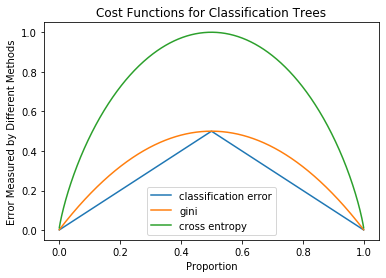

In [2]:
prob = np.linspace(0, 1, num=1000)[1:-1]
cls_err = [1 - max(i, 1-i) for i in prob]
gini_err = [2*i*(1-i) for i in prob]
cren_err = [-(i*np.log2(i)+(1-i)*np.log2(1-i)) for i in prob]

plt.plot(prob,cls_err,label='classification error')
plt.plot(prob,gini_err,label='gini')
plt.plot(prob,cren_err,label='cross entropy')
plt.ylabel('Error Measured by Different Methods')
plt.xlabel('Proportion')
plt.title('Cost Functions for Classification Trees')
plt.legend()
plt.show()

In general, we want to have a loose stopping criterion to grow the decision tree and then use a stricter method to prune the tree to remove branches that contribute to overfitting. Therefore, as shown above, classification error is the loosest and therefore better for growing the tree, and cross-entropy method is the strictest and better for pruning the tree.

## 2. Estimate the Models

In [3]:
train_data = pd.read_csv('data/gss_train.csv')
test_data = pd.read_csv('data/gss_test.csv')
train_data.shape, test_data.shape

((1476, 56), (493, 56))

In [4]:
kf = KFold(n_splits=10)
X_train = train_data.drop('colrac', axis=1)
y_train = train_data['colrac']

In [5]:
## Logistic Regression
log_pred = cross_val_predict(LogisticRegression(solver='liblinear'), 
                             X_train, y_train, cv = 10)
## Naive Bayes
nb_pred  = cross_val_predict(GaussianNB(), X_train, y_train, cv = 10)

In [6]:
## Elastic Net Regression
ENR_model = ElasticNetCV(cv=10, random_state=0).fit(X_train, y_train)
print(f'best alpha', ENR_model.alpha_)
print(f'best l1_ratio', ENR_model.l1_ratio_)

best alpha 0.0038452641680228584
best l1_ratio 0.5


In [8]:
## Decision Tree
parameters = {
    "min_samples_split": [0.1, 0.3, 0.5],
    "min_samples_leaf": [0.1, 0.3, 0.5],
    "max_depth":range(1,20),
    }

clf_dt = GridSearchCV(DecisionTreeClassifier(), parameters, cv = 10).fit(X_train, y_train)
best_cart_model = clf_dt.best_estimator_
print(round(clf_dt.best_score_, 4), clf_dt.best_params_) 

0.7656 {'max_depth': 4, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}


In [9]:
## Random Forest
parameters = {
    'n_estimators': range(20,50),
    "max_depth":range(1,20),
    }
clf_rf = GridSearchCV(RandomForestClassifier(), parameters, cv = 10).fit(X_train, y_train)
best_rf_model = clf_rf.best_estimator_
print(round(clf_rf.best_score_, 4), clf_rf.best_params_) 

0.8089 {'max_depth': 16, 'n_estimators': 43}


In [10]:
## Gradient Boosting
parameters = {
    'n_estimators': [20, 30, 40, 50],
    "max_depth": [11, 13, 15],
    "learning_rate": [0.025, 0.2]
    }

clf_gb = GridSearchCV(GradientBoostingClassifier(), parameters, cv = 10).fit(X_train, y_train)
best_gb_model = clf_gb.best_estimator_
print(clf_gb.best_score_, clf_gb.best_params_) 

0.763550135501355 {'learning_rate': 0.2, 'max_depth': 11, 'n_estimators': 50}


In [11]:
## Bagging
parameters = {
    "base_estimator": [DecisionTreeClassifier()],
    "n_estimators": range(20,50)
    }
clf_bag = GridSearchCV(BaggingClassifier(), parameters, cv = 10).fit(X_train, y_train)
best_bag_model = clf_bag.best_estimator_
print(clf_bag.best_score_, clf_bag.best_params_) 

0.7933604336043361 {'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'n_estimators': 38}


## 3, 4. Model Evaluation

In [12]:
best_log = LogisticRegression(solver='liblinear').fit(X_train, y_train)
best_NB = GaussianNB().fit(X_train, y_train)
best_EN = SGDClassifier(alpha = ENR_model.alpha_, 
                        l1_ratio = ENR_model.l1_ratio_).fit(X_train, y_train)

### Cross-validated error rate

In [13]:
err_log = 1 - cross_val_score(LogisticRegression(solver='liblinear'), 
                          X_train, y_train, cv = 10).mean()
err_nb = 1 - cross_val_score(GaussianNB(), X_train, y_train, cv = 10).mean()
err_elstic = 1 - cross_val_score(best_EN, X_train, y_train, cv = 10).mean()

print('log', round(err_log, 4))
print('Naive Bayes', round(err_nb, 4))
print('Elastic Net', round(err_elstic, 4))
print('Cart', round(1 - clf_dt.best_score_, 4))
print('Random Forest', round(1 - clf_rf.best_score_, 4))
print('Boosting', round(1 - clf_gb.best_score_, 4))
print('Bagging', round(1 - clf_bag.best_score_, 4))

log 0.2073
Naive Bayes 0.2656
Elastic Net 0.2587
Cart 0.2344
Random Forest 0.1911
Boosting 0.2364
Bagging 0.2066


### ROC/AUC

In [18]:
pred_log = LogisticRegression(solver='liblinear').fit(X_train, y_train).predict(X_train)
pred_NB = GaussianNB().fit(X_train, y_train).predict(X_train)
pred_EN = best_EN.fit(X_train, y_train).predict(X_train)

In [20]:
roc = roc_auc_score(pred_log, y_train)
print('log', round(roc, 4))
roc = roc_auc_score(pred_NB, y_train)
print('Naive Bayes', round(roc, 4))
roc = roc_auc_score(pred_EN.astype(int), y_train)
print('Elastic Net', round(roc, 4))

roc = roc_auc_score(clf_dt.predict(X_train), y_train)
print('Cart', round(roc, 4))
roc = roc_auc_score(clf_rf.predict(X_train), y_train)
print('Random Forest', round(roc, 4))
roc = roc_auc_score(clf_gb.predict(X_train), y_train)
print('Boosting', round(roc, 4))
roc = roc_auc_score(clf_bag.predict(X_train), y_train)
print('Bagging', round(roc, 4))

log 0.8166
Naive Bayes 0.7425
Elastic Net 0.7515
Cart 0.7847
Random Forest 1.0
Boosting 1.0
Bagging 1.0


Random Forest has the lowest cv-error rate and is also one of the models that get the highest ROC/AUC score. Therefore, it is the best model.

## 5. Evaluate the best model: Random Forest

In [21]:
X_test = test_data.drop('colrac', axis=1)
y_test = test_data['colrac']

In [29]:
pred = clf_rf.predict(X_train)
err = sum(pred != y_train)/ len(y_train)
err

0.0

In [26]:
pred = clf_rf.predict(X_test)
err = sum(pred != y_test)/ len(y_test)
roc = roc_auc_score(pred, y_test)

print('classification error', err)
print('ROC/AUC', roc)

classification error 0.20486815415821502
ROC/AUC 0.8037730243612597


The classification error is about 20% (the classification error in the train data is 0). ROC/AUC decreased from 1 to 0.8. In all, the generalization is acceptable not quite good. This is because of overfitting--the model worked overly well on the train data and probably did not effectively prune the tree branches.

## PDPs/ICE

In [66]:
from pdpbox import pdp, info_plots

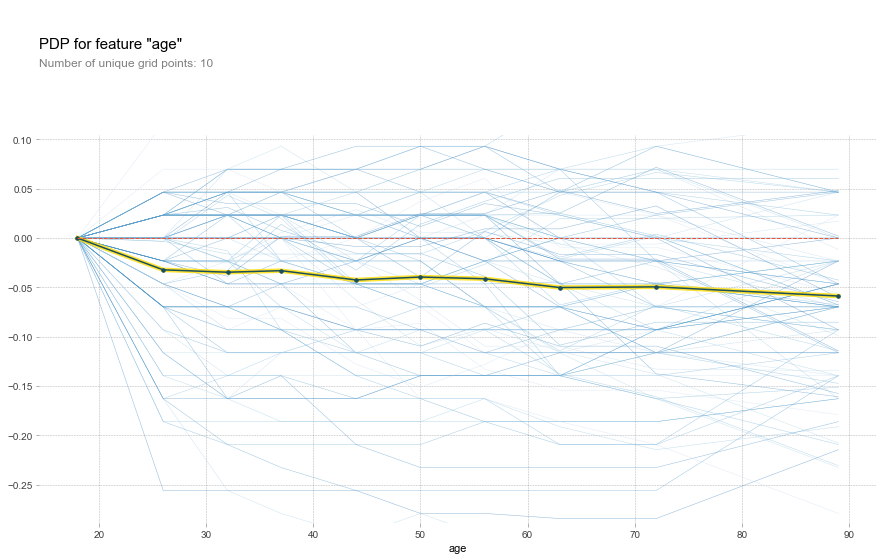

In [72]:
pdp_age = pdp.pdp_isolate(model=clf_rf, dataset=X_train, 
                          model_features=X_train.columns, feature='age')
fig, axes = pdp.pdp_plot(pdp_age, 'age', plot_lines=True, frac_to_plot=100)

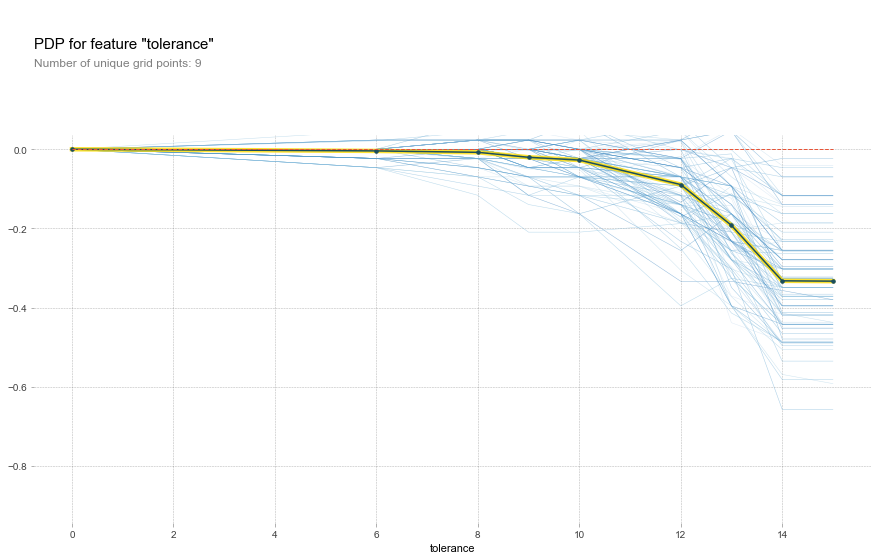

In [70]:
pdp_tol = pdp.pdp_isolate(model=clf_rf, dataset=X_train, 
                          model_features=X_train.columns, feature='tolerance')
fig, axes = pdp.pdp_plot(pdp_tol, 'tolerance', plot_lines=True, frac_to_plot=100)

The partial dependence plot (PDP) shows the marginal effect a feature has on the predicted outcome. As shown from the plots above. The change of age does not quite change its influence on the predicted outcome after people are about aged 26+. Surprisingly, for people aged 26+, they are more likely to support that the racist professor should not be allowed to teach. For people whose tolerance is under 10, the marginal effect of tolerance is not strong at all. But for those with 10+ level of tolerance, the increase of tolerance siginificantly increases the likelihood that a person think the racist professor should not be allowed to teach.